In [32]:
import numpy as np
import pandas as pd
from numpy import mean
from numpy import std
from pandas import read_csv
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold


In [33]:
full_path='../data/processed/mean_impute_all_features.csv'
# def data (full_path):
dataframe = read_csv(full_path)
dataframe.reset_index(drop=True, inplace=True)
X, y= dataframe.drop('gestational dm', axis=1), dataframe['gestational dm'] 
seed=10
    #Splitting X,y into Train & Test
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)
X.shape, y.shape

((132, 9), (132,))

In [34]:
#Functions:
# Check if the labels are well shuffled in train and test set, to avoid imbalanced data
def bin_count(y_train, y_test):
    """
    Function to check class distribution in train and test set
    Arguments:y_train and y_test
    Returns: Prints bincount per class for each set
    """
    a,b=np.bincount(y_train)
    print(f"Percentage of data distribution in the train set:")
    print(round(a/(a+b)*100,2))
    print(round(b/(a+b)*100,2))
    print("-------------------")
    x,y=np.bincount(y_test)
    print(f"Percentage of data distribution in the test set:")
    print(round(x/(x+y)*100,2))
    print(round(y/(x+y)*100,2))

#Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
def conf_matrix(y_test, y_pred):
    """Function to generate confusion matrix and generate report
       Arg: true labels and predicted labels array
    """
    cm = confusion_matrix(y_test, y_pred)
    f, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cm,fmt=".0f", annot=True,linewidths=0.2, linecolor="purple", ax=ax)
    plt.xlabel("Predicted")
    plt.ylabel("Grand Truth")
    plt.show()
    TN = cm[0,0]
    TP = cm[1,1]
    FN = cm[1,0]
    FP = cm[0,1]
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    F1_Score = 2*(Recall * Precision) / (Recall + Precision)
    return pd.DataFrame([[Precision, Recall, F1_Score]],columns=["Precision", "Recall", "F1 Score"], index=["Results"])

#Train random forst model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
def randomForest(X_train, X_test, y_train, y_test):
    """
    Function to train model
    Argumens: train and test data
    Returns: Score, classification report, model
    """
    rf = RandomForestClassifier(random_state=seed)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred) * 100
    report = classification_report(y_test, y_pred)
    return score, report, rf, y_pred

In [15]:
correlated_features = set()
correlation_matrix = X.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
correlated_features

X.columns


Index(['age (years)', 'ethnicity', 'mean diastolic bp (mmhg)',
       'mean systolic bp (mmhg)', 'central armellini fat (mm)',
       'current gestational age', 'pregnancies (number)',
       'first fasting glucose (mg/dl)', 'bmi pregestational (kg/m)'],
      dtype='object')

In [85]:
# distributions = [
#     ('Data after standard scaling',
#         StandardScaler().fit_transform(X)),
#     ('Data after min-max scaling',
#         MinMaxScaler().fit_transform(X)),
#     ('Data after sample-wise L2 normalizing',
#         Normalizer().fit_transform(X)),
# ]
#Scaling continuous features using StandardScaler
from sklearn.preprocessing import StandardScaler
minMaxScaler = MinMaxScaler()
columns_to_scale = ['age (years)', 'mean diastolic bp (mmhg)', 'mean systolic bp (mmhg)', 'central armellini fat (mm)', 'current gestational age','pregnancies (number)', 'first fasting glucose (mg/dl)', 'bmi pregestational (kg/m)' ]
X[columns_to_scale] = minMaxScaler.fit_transform(X[columns_to_scale])
X.head()
# s=StandardScaler().fit_transform(X)
# m=MinMaxScaler().fit_transform(X)
# n=Normalizer().fit_transform(X)
# np.mean(s),np.std(s)

,age (years),ethnicity,mean diastolic bp (mmhg),mean systolic bp (mmhg),central armellini fat (mm),current gestational age,pregnancies (number),first fasting glucose (mg/dl),bmi pregestational (kg/m)
0,0.178571,0.0,0.448980,0.454545,0.188494,0.424460,0.000,0.392593,0.439697
1,0.464286,0.0,0.489796,0.285714,0.372093,0.381295,0.000,0.296296,0.143869
2,0.214286,1.0,0.387755,0.337662,0.351285,0.460432,0.000,0.481481,0.141593
3,0.357143,0.0,0.836735,1.000000,0.329253,0.719424,0.375,0.392593,1.000000
4,0.642857,1.0,0.561224,0.610390,0.674419,0.359712,0.125,0.481481,0.380278


## Feature Selection

Optimal number of features : 8


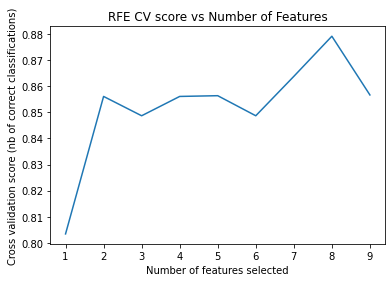

<Figure size 432x288 with 0 Axes>

In [19]:
#RFECV using LR estimator

rfc = RandomForestClassifier(random_state=101)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(5), scoring='accuracy')
selector=rfecv.fit(X, y)
selector
print("Optimal number of features : %d" % selector.n_features_)

plt.figure()
plt.title('RFE CV score vs Number of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()
plt.savefig("Feature_selection")

In [20]:
feature_names=X.columns
feature_importance = list(zip(feature_names, rfecv.support_))
new_features = []
for key,value in enumerate(feature_importance):
    if(value[1]) == True:
        new_features.append(value[0])
print(new_features)

['age (years)', 'mean diastolic bp (mmhg)', 'mean systolic bp (mmhg)', 'central armellini fat (mm)', 'current gestational age', 'pregnancies (number)', 'first fasting glucose (mg/dl)', 'bmi pregestational (kg/m)']


In [150]:
#First drop only the feature suggested
features=X.drop(['ethnicity'], axis=1)
features.head()

#Splitting X,y into Train & Test
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.20, random_state=seed, stratify=y)
bin_count(y_train, y_test)

Percentage of data distribution in the train set:
86.67
13.33
-------------------
Percentage of data distribution in the test set:
85.19
14.81


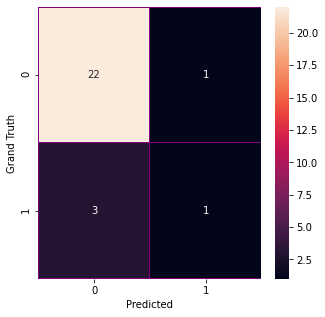

,Precision,Recall,F1 Score
Results,0.5,0.25,0.333333


In [29]:
#Train default model
score, report, rf, y_pred =randomForest(X_train, X_test, y_train, y_test)
conf_matrix(y_test,y_pred)

In [92]:
#Redo by dropping correlated features:
data=X.drop(['ethnicity', 'central armellini fat (mm)', 'mean diastolic bp (mmhg)'], axis=1)
data.tail()
#Splitting X,y into Train & Test
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.20, random_state=seed, stratify=y)
X_train.shape, y_train.shape

((105, 6), (105,))

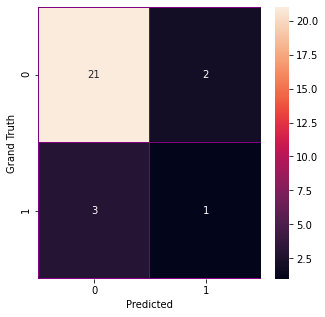

,Precision,Recall,F1 Score
Results,0.333333,0.25,0.285714


In [31]:
score, report, rf, y_pred =randomForest(X_train, X_test, y_train, y_test)
conf_matrix(y_test,y_pred)

In [94]:
#Repeat the up, without dropping ethnicity:
#Redo by dropping correlated features:
data=X.drop(['central armellini fat (mm)', 'mean diastolic bp (mmhg)'], axis=1)
data.tail()
#Splitting X,y into Train & Test
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.20, random_state=seed, stratify=y)
X_train.shape, y_train.shape

((105, 7), (105,))

In [96]:
#Repeat the up, without dropping ethnicity:
#Redo by dropping correlated features:
data=X.drop(['ethnicity', 'mean diastolic bp (mmhg)'], axis=1)
data.tail()
#Splitting X,y into Train & Test
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.20, random_state=seed, stratify=y)
X_train.shape, y_train.shape

((105, 7), (105,))

In [100]:
#Lets try FE a new column (SysP-DiasP),
X["BP"]=X['mean systolic bp (mmhg)'] - X['mean diastolic bp (mmhg)']
data=X.drop(['ethnicity', 'mean diastolic bp (mmhg)', 'mean systolic bp (mmhg)'], axis=1)
data.tail()
#Splitting X,y into Train & Test
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.20, random_state=seed, stratify=y)
X_train.shape, y_train.shape

((105, 7), (105,))

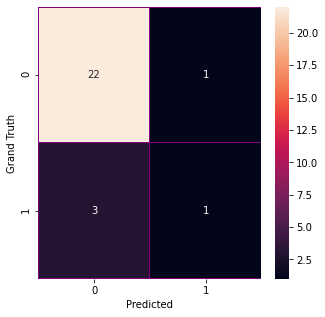

,Precision,Recall,F1 Score
Results,0.5,0.25,0.333333


In [33]:
score, report, rf, y_pred =randomForest(X_train, X_test, y_train, y_test)
conf_matrix(y_test,y_pred)

In [34]:
score

85.18518518518519

In [59]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

models = []
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier(random_state=seed)))
models.append(('GB', GradientBoostingClassifier(random_state=seed)))

#Test accuracy and score
random_state=10
names = []
scores = []
y_pred_list=[]
for name, model in models:
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
    names.append(name)
tr_split = pd.DataFrame({'Name': names, 'Score': scores})
print(tr_split)

  Name     Score
0  GNB  0.851852
1   RF  0.851852
2   GB  0.814815


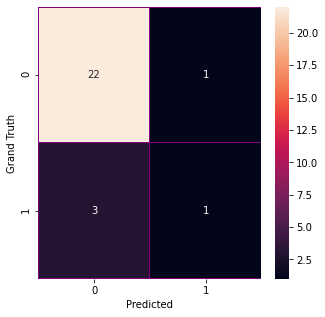

,Precision,Recall,F1 Score
Results,0.5,0.25,0.333333


In [103]:
from sklearn.linear_model import LogisticRegression
model=GaussianNB().fit(X_train, y_train)
y_pred=model.predict(X_test)
accuracy_score(y_test, y_pred)
conf_matrix(y_test,y_pred)

Best results for GNB, by dropping ethnicity and ethn+mean diastolic pressure gives similar result.
Scaling doesn't affect the result.

In [104]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(22, 1, 3, 1)

## Create balance dataset

In [35]:
from sklearn.utils import resample
# concatenate our training data back together as resampling should be done before splitting of target and feature of training data
# X = pd.concat([X_train, y_train], axis=1)
# X.head()

# separate minority and majority classes
majority = dataframe[dataframe['gestational dm']==0]
minority = dataframe[dataframe['gestational dm']==1]

# upsample minority
upsampled = resample(minority,
                          replace=True, # sample with replacement
                          n_samples=len(majority), # match number in majority class
                          random_state=seed) # reproducible results

# combine majority and upsampled minority
upsampled_data = pd.concat([majority, upsampled])


# checking counts after resampling from both the techniques
print(f"Oversampling value counts: {upsampled_data['gestational dm'].value_counts()}")


Oversampling value counts: 1    114
0    114
Name: gestational dm, dtype: int64


In [36]:
# trying logistic regression again with the oversampled balanced dataset
# dataset=upsampled_data.drop(['level_0', 'index'], axis=1)
# dataset.tail()
y = upsampled_data['gestational dm']
X = upsampled_data.drop(['gestational dm','ethnicity', 'central armellini fat (mm)', 'mean diastolic bp (mmhg)'], axis=1)
X.shape, y.shape
# # y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed, stratify=y)
X_train.shape, y_train.shape

# model=GaussianNB().fit(X_train, y_train)
# y_pred=model.predict(X_test)
# score=accuracy_score(y_test, y_pred)
# conf_matrix(y_test,y_pred)

((182, 6), (182,))

In [173]:
X_train.head()

,age (years),mean systolic bp (mmhg),current gestational age,pregnancies (number),first fasting glucose (mg/dl),bmi pregestational (kg/m)
80,30,113.0,16.2,3.0,78.0,28.20
90,29,114.5,7.3,2.0,81.2,23.33
99,30,125.5,13.6,1.0,66.0,19.44
114,34,115.0,17.4,8.0,81.2,37.16
76,20,113.5,11.4,1.0,109.0,29.34


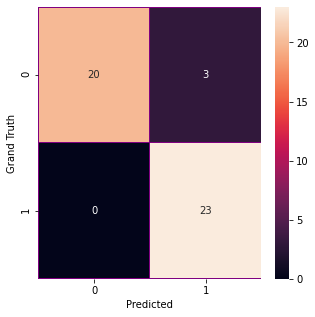

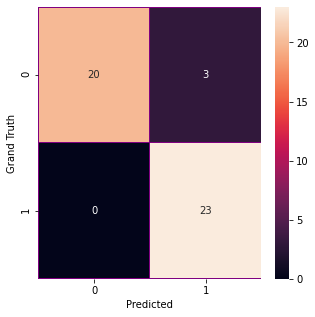

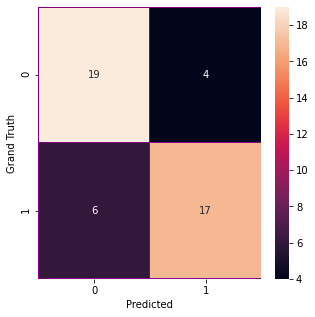

(         Precision  Recall  F1 Score
 Results   0.884615     1.0  0.938776,
          Precision  Recall  F1 Score
 Results   0.884615     1.0  0.938776,
          Precision   Recall  F1 Score
 Results   0.809524  0.73913  0.772727)

In [60]:
# #Balance class weight drop ethnicity:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

rf_model=RandomForestClassifier(random_state=seed).fit(X_train, y_train)
gb_model=RandomForestClassifier(random_state=seed).fit(X_train, y_train)
GradientBoostingClassifier(random_state=seed)
gnb_model=GaussianNB().fit(X_train, y_train)
rf_pred=rf_model.predict(X_test)
gb_pred=gb_model.predict(X_test)
gnb_pred=gnb_model.predict(X_test)
score=accuracy_score(y_test, rf_pred)
conf_matrix(y_test,rf_pred),conf_matrix(y_test,gb_pred),conf_matrix(y_test,gnb_pred)
# X_train.shape

In [38]:
#Test a sample:
Normal=[20, 113, 16.2, 3, 80, 29]
Between=[28, 120, 16.2, 4, 83, 31]
Pos=[33, 137, 18, 5, 86, 35.8]
B=np.array(Pos)
# B
C=B.reshape(1, -1)
rf_model.predict_proba(C), gb_model.predict_proba(C), gnb_model.predict_proba(C)

(array([[0.45, 0.55]]),
 array([[0.45, 0.55]]),
 array([[0.10806874, 0.89193126]]))

In [39]:
rf_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [44]:
# Get numerical feature importances
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.2541508643770216, 'first fasting glucose (mg/dl)'),
 (0.22744195562344355, 'pregnancies (number)'),
 (0.17139070738135395, 'bmi pregestational (kg/m)'),
 (0.12878442191531328, 'age (years)'),
 (0.12302052340147678, 'current gestational age'),
 (0.09521152730139079, 'mean systolic bp (mmhg)')]

In [47]:
# # Import tools needed for visualization
# from sklearn.tree import export_graphviz
# import pydot
# # Pull out one tree from the forest
# tree = rf_model.estimators_[5]
# # Export the image to a dot file
# export_graphviz(tree, out_file = 'tree.dot', feature_names = X.columns, rounded = True, precision = 1)
# # Use dot file to create a graph
# (graph, ) = pydot.graph_from_dot_file('tree.dot')
# # Write graph to a png file
# graph.write_png('tree.png')

In [29]:
# import os
# export_graphviz(tree,
#                 feature_names=X.columns,
#                 filled=True,
#                 rounded=True)
# os.system('dot -Tpng tree.dot -o tree.png')

32512

In [48]:
# import matplotlib.pyplot as plt
# import cv2
# %matplotlib inline
# img = cv2.imread('tree.png')
# plt.figure(figsize = (20, 20))
# plt.imshow(img)

In [51]:
#Hyperparameter tuning:(Altogether, there are 2 * 12 * 2 * 3 * 3 * 10 = 4320 settings!)

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [55]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=seed, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.2min finished


{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': False}

In [56]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(train_features, train_labels)
base_accuracy = evaluate(base_model, test_features, test_labels)
Model Performance
Average Error: 3.9199 degrees.
Accuracy = 93.36%.
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, test_features, test_labels)
Model Performance
Average Error: 3.7152 degrees.
Accuracy = 93.73%.
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))
Improvement of 0.40%.

TypeError: __init__() got an unexpected keyword argument 'param_distributions'

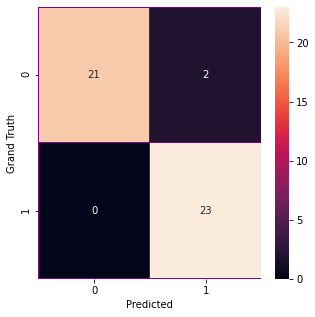

,Precision,Recall,F1 Score
Results,0.92,1.0,0.958333


In [59]:
best_tree = rf_random.best_estimator_.fit(X_train, y_train)
# best_tree.fit(X_train, y_train)
best_pred=best_tree.predict(X_test)
best_score=accuracy_score(y_test, best_pred)
conf_matrix(y_test,best_pred)

In [61]:
print('Improvement of {:0.2f}%.'.format( 100 * (best_score - score) / score))

Improvement of 2.33%.


Reference: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74